First, I import the packages I will need for the analysis and set a random seed for reproducibility of results.

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import theano.tensor as tt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

np.random.seed(42)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Next, I load the dataset and take a look at the first 5 rows.

In [2]:
#load dataset
data = sns.load_dataset("iris")
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Next, I check the balance of our target variable, 'species'

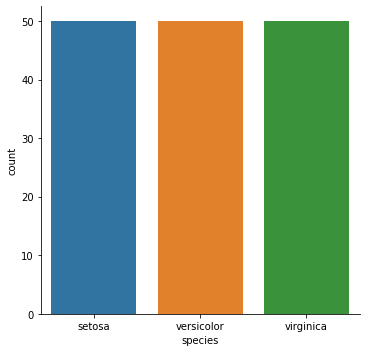

In [3]:
#check class balance of target variable
sns.catplot(x="species", kind="count", data=data)

The classes are balanced with 50 observations per class and therefore will not require us to address imbalance. Next, I take a look at the distribution of our predictor variables, sepal_length, sepal_width, petal_length and petal_width.

In [4]:
#check distribution of predictors
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Next, I plot the variation of each predictor in the diagonal in the form of KDE plots separated by class, as well as the covariation of predictors with each other in the form of scatterplots (also separated by class).

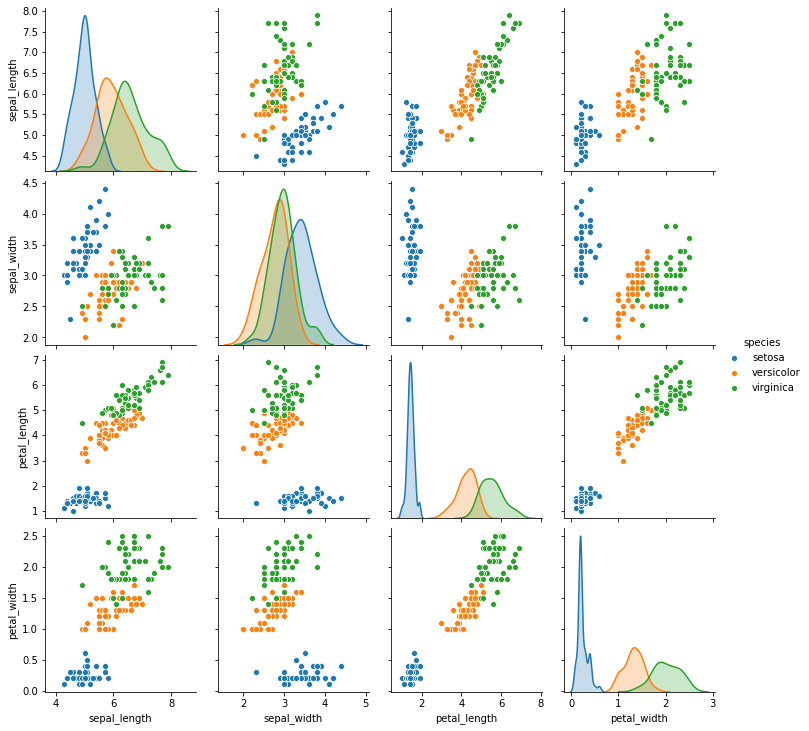

In [5]:
#check variation and covariation of predictors with class labels
sns.pairplot(data, hue='species')

From looking at the plots it looks like both petal attributes do a decent job separating the classes on their own (especially differentiating setosa from the other two species). It also appears we can get good separation when looking at the petal attributes against the sepal attributes in the scatterplots (such as petal_length vs sepal_width). There also appears to be a lot of correlated variables, especially when looking at the petal_length vs petal_width scatterplot whose observations appear to lie on a line of slope near 1 (meaning perfect positive correlation). I calculate the actual correlations and plot a heatmap next.

In [6]:
#correlation matrix of predictors
data.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


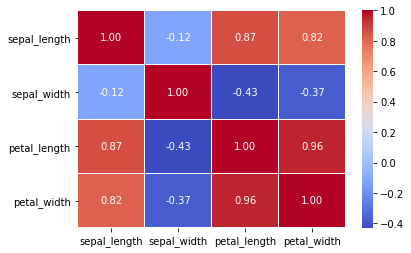

In [7]:
#correlation of predictors heatmap
sns.heatmap(round(data.corr(),2), annot=True,cmap="coolwarm",fmt='.2f',linewidths=.05)

As we could see from the scatterplots, there is in fact a lot of correlation in the dataset. Not only are petal_length and petal_width highly correlated, but the petal attributes are also highly correlated with sepal_length. Such high correlation leads to the regression beta coefficients becoming unstable and taking on unreasonably large values, as well as having very large credible intervals due to uncertainty in the model. When using frequentist regression, this type of correlation can be addressed with a ridge or lasso penalty that essentially shrinks the betas towards 0. In a Bayesian setting, a similar effect can be achieved using informative or weakly informative priors in order to introduce more bias into the model. I will use a weakly informative prior suggested by Andrew Gelman here: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations.

First, I set up the design matrix X by scaling the independent variable values to have a mean of 0 and standard deviation of 0.5 and encode the outcome vector.

In [8]:
#prepare data
#Set up Design Matrix: center data and divide by 2 standard deviations to achieve mean of 0 and std dev of .5
X = data[['sepal_length','sepal_width','petal_length','petal_width']].values
X_standard = (X - X.mean(axis=0))/(2*X.std(axis=0))

#create outcome vector
y = pd.Categorical(data['species']).codes

Next, I define the model. Our alpha (or the "intercept" in the linear component alpha + beta*X) will come from a Normal distribution with mean of 0 and standard deviation of 2.5. Our beta will come from the Student-T distribution which was suggested as a weakly informative prior by Gelman in the link above. It is also more robust to outliers than a Normal prior. It will have a mean of 0, standard deviation of 2.5 and nu (or degrees of freedom) of 7. The range for nu suggested by Gelman is from 3-7, and I chose 7 to have thinner tails for the distribution than the lower potential nu values. The linear component is then passed through a softmax function to generate a theta which is a vector of 3 probabilities (one for each class that the observation may belong to). Finally, the likelihood of this particular model is Categorical, which is a generalization of the Bernoulli likelihood used in logistic regression to more than 2 possible classes.

In [9]:
with pm.Model() as model_softmax:
    #priors
    alpha = pm.Normal('alpha', mu=0, sd=2.5, shape=2)
    beta = pm.StudentT('beta', mu=0, sd = 2.5, nu = 7,shape=(4,2))
    
    #add baseline class (setosa)
    alpha_full = tt.concatenate([[0] , alpha])
    beta_full = tt.concatenate([np.zeros((4,1)) , beta], axis=1)
    
    #linear component
    mu =  pm.Deterministic('mu',alpha_full + pm.math.dot(X_standard, beta_full))
    
    #inverse link function
    theta = tt.nnet.softmax(mu)

    #define likelihood
    y_likelihood = pm.Categorical('y_likelihood', p=theta, observed=y)
    
    #draw 1000 posterior samples from 4 chains
    trace = pm.sample(1000,chains = 4)

C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [33:08<00:00,  3.02draws/s] 
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  

After sampling posteriors using 4 Markov Chains in the NUTS sampler, I take a look at the posterior distributions of alphas and betas (keep in mind that setosa is not here since it is the baseline class). 

C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\pymc3\plots\__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A443408E10>,
      dtype=object)

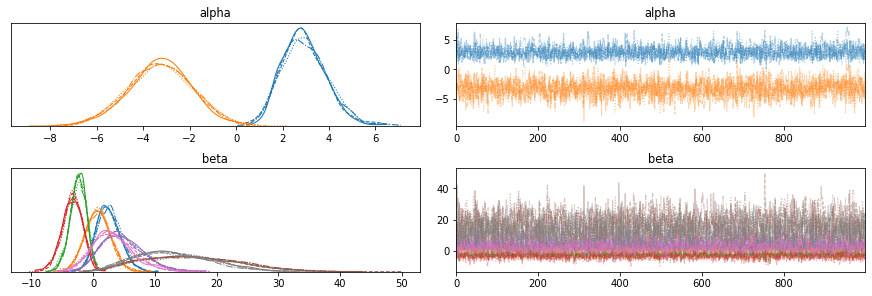

In [10]:
pm.traceplot(trace,varnames=['alpha','beta'])

It looks like the betas for petal_length and petal_width for both classes are very dispersed with a large MAP and seem to be overlapping, which is a direct result of the correlation mentioned previously. It may be a good idea to enforce an even more informative prior to shrink them, or remove one of the two variables from the model completely. Another alternative (but one that has a high interpretability cost) is to get rid of their multicollinearity completely by making new orthogonal/independent variables using PCA.

Next, I look at the summary that gives us the coeffcient values and credible intervals for each parameter. 

In [11]:
pm.summary(trace,varnames=['alpha','beta'])

C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\pymc3\stats\__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
C:\Users\rguse\Anaconda3\envs\conda_env\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.957,0.977,1.185,4.766,0.021,0.017,2120.0,1735.0,2335.0,1803.0,1.0
alpha[1],-3.273,1.384,-5.938,-0.713,0.028,0.020,2444.0,2444.0,2443.0,2290.0,1.0
"beta[0,0]",2.503,1.928,-0.978,6.155,0.039,0.030,2387.0,2098.0,2428.0,2609.0,1.0
"beta[0,1]",0.761,2.039,-2.963,4.500,0.044,0.033,2162.0,1870.0,2175.0,2530.0,1.0
"beta[1,0]",-2.443,1.316,-4.994,-0.055,0.027,0.020,2433.0,2252.0,2454.0,2480.0,1.0
"beta[1,1]",-3.359,1.676,-6.513,-0.235,0.034,0.025,2468.0,2289.0,2492.0,2370.0,1.0
"beta[2,0]",4.783,3.417,-1.340,11.135,0.098,0.071,1213.0,1167.0,1276.0,1401.0,1.0
"beta[2,1]",16.020,7.659,2.653,29.992,0.217,0.154,1240.0,1240.0,1272.0,1919.0,1.0
"beta[3,0]",3.250,3.345,-2.507,9.960,0.092,0.066,1322.0,1299.0,1370.0,1641.0,1.0
"beta[3,1]",12.985,6.167,2.327,24.624,0.169,0.119,1336.0,1336.0,1383.0,1987.0,1.0


As opposed to fequentist model fitting, the HPD (credible) intervals are actual probabilities, therefore, we can make statements such as there is a 95% probability that beta_1_1 (sepal_width parameter of the virginica class) falls between -6.513 and -0.235. Once again, we can see from the table a high mean and a large standard deviation for the petal_length and petal_width posteriors of virginica (beta_2_1 and beta_3_1 respectively). Versicolor's petal_length and petal_width posterior intervals (beta_2_0 and beta_3_0) look fairly large as well compared to all the other betas apart from beta_2_1 and beta_3_1.

Next, let's look at the overall model accuracy by comparing the model's predictions vs the actual labels.

In [12]:
#caclulate linear components/mus
linear_components = trace['alpha'].mean(axis=0) + np.dot(X_standard, trace['beta'].mean(axis=0))
linear_components_full = np.append(np.zeros([len(linear_components),1]),linear_components,1)
#create class probability output vector
y_probs = []
#apply softmax
for linear_component in linear_components_full:
    y_probs.append(np.exp(linear_component)/np.sum(np.exp(linear_component), axis=0))
#calculate % of time highest probability class matches the actual class 
np.sum(y == np.argmax(y_probs, axis=1))/len(y)

0.9733333333333334

97.3% of the observations being properly classified is a pretty good result! Finally, let look at a more detailed breakdown of the model's performance by looking at the precision, recall and their harmonic mean (f1 score) by class.

In [13]:
print(classification_report(y, np.argmax(y_probs, axis=1), digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.979     0.940     0.959        50
           2      0.942     0.980     0.961        50

    accuracy                          0.973       150
   macro avg      0.974     0.973     0.973       150
weighted avg      0.974     0.973     0.973       150



Looks like our model is performing quite well. In particular, it's able differentiate setosa perfectly while doing a decent job with the other two classes as well. 

In order to truly evaluate our model, we would want to keep a holdout test set unseen by the model in order to evaluate its generalization performance. Another good practice is to try other models (such as ensemble machine learning models like gradient boosting) and compare the performance with the Bayesian approach. Still, the interpretability of a Bayesian model is one of its greatest strengths, and it may be advantageous to stick with it despite better performance from other, less interpretable methods. In particular, Bayesian methods, give us probabilities of an observation belonging to each class (which is rarely available from pure machine learning methods) and also account for uncertainty around the beta coefficients (an uncertainity that is often ignored in pure frequentist methods).

Thank you for reading and I hope you found this analysis a little interesting.